In [1]:
import numpy as np
import pandas as pd
from pcap_analysis import *

crawl_data_dir = '/mnt/iot-house/crawl-data/roku-data-20190329-122144'
post_process_dir = join(crawl_data_dir, 'post-process')



In [2]:
#Create Timestamp DF
channel_timestamps = load_timestamp_json(crawl_data_dir)
df_ch_timestamps = pd.DataFrame(channel_timestamps).transpose().reset_index()
df_ch_timestamps.rename(columns={'index': 'Channel Name'}, inplace=True)

#Generate Global (All SSL/TCP Streams)
global_df = gen_global_df(post_process_dir)

#Add SSL artifacts 
global_df_ssl = add_ssl_features(global_df, post_process_dir)
#Drop all duplicates
global_df_ssl = global_df_ssl.drop_duplicates(subset=['Channel Name', 'ip.dst', 'MITM Attemp',  'SSL Failure'])
print(global_df.head())

Loading timestamp data from /mnt/iot-house/crawl-data/roku-data-20190329-122144
Generating Global DF from /mnt/iot-house/crawl-data/roku-data-20190329-122144/post-process 
Adding SSL features to DF from /mnt/iot-house/crawl-data/roku-data-20190329-122144/post-process 
   tcp.stream  frame.time_epoch       ip.src          ip.dst Channel Name  \
0           9      1.553906e+09  10.42.0.119   34.193.43.251       231158   
1          11      1.553906e+09  10.42.0.119    52.85.101.37       231158   
2          14      1.553906e+09  10.42.0.119  54.174.219.117       231158   
3          15      1.553906e+09  10.42.0.119   34.193.43.251       231158   
4          16      1.553906e+09  10.42.0.119    23.22.241.63       231158   

   MITM Attemp  SSL Failure  
0            0            0  
1            0            0  
2            0            0  
3            0            0  
4            0            0  


In [3]:
######Timestamp Analysis######
##############################

#Merge global_df with timestamp_df
global_df_merged = pd.merge(global_df_ssl, df_ch_timestamps, on=['Channel Name'])
global_df_merged['epoch'] = np.nan

epoch_list = list(df_ch_timestamps)
epoch_list.remove('Channel Name')


#Populate epoch column for channel based on
#the timestamp of SYN packet.
for epoch in epoch_list:
    global_df_merged['epoch'] = np.where(global_df_merged['frame.time_epoch']>global_df_merged[epoch],
                                     epoch, global_df_merged['epoch'])



['launch-1', 'launch-10', 'launch-2', 'launch-3', 'launch-4', 'launch-5', 'launch-6', 'launch-7', 'launch-8', 'launch-9']
launch-1 saw 544 new end point
launch-10 saw 0 new end point
launch-2 saw 522 new end point
launch-3 saw 378 new end point
launch-4 saw 396 new end point
launch-5 saw 370 new end point
launch-6 saw 188 new end point
launch-7 saw 339 new end point
launch-8 saw 234 new end point
launch-9 saw 606 new end point


([<matplotlib.axis.XTick at 0x7fe82657c860>,
 <a list of 10 Text xticklabel objects>)

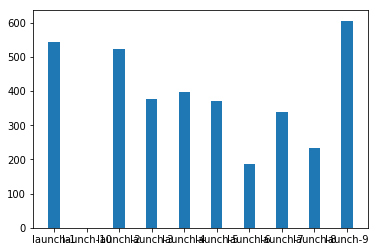

In [6]:
#Graph
import numpy as np
import matplotlib.pyplot as plt


labels = [e for e in epoch_list if 'launch' in e]
print(labels)
new_endpoints_df = global_df_merged.drop_duplicates(subset=['Channel Name', 'ip.dst'])

new_endpoints_count = []
for epoch in labels:
    df_epoch = new_endpoints_df.loc[global_df_merged['epoch'] == epoch]
    total_len = len(df_epoch)
    print( "%s saw %s new end point" % (epoch, str(total_len)) )
    new_endpoints_count.append(total_len)

N = len(labels)
ind = np.arange(N)
width = 0.35

plt1 = plt.figure(1)
p1 = plt.bar(ind, new_endpoints_count, width)
plt.xticks(ind, labels)

#plt1.show()


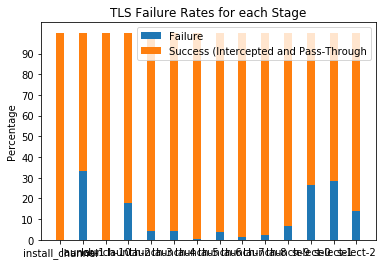

In [5]:
plt2 = plt.figure(2)
labels = epoch_list
failure_percentage = []
success_percentage = []
for epoch in epoch_list:
    df_epoch = global_df_merged.loc[global_df_merged['epoch'] == epoch]
    total_len = len(df_epoch)
    failure_len = len(df_epoch.loc[df_epoch['SSL Failure'] == 1])
    if total_len == 0:
        failure_percent = 0
        success_percent = 100
    else:
        failure_percent = 100 * float(failure_len)/float(total_len)
        success_percent = 100 - failure_percent
    failure_percentage.append(failure_percent)
    success_percentage.append(success_percent)
    #print(failure_percentage)
    #print(success_percentage)
    #print('******')




N = len(epoch_list)
ind = np.arange(N)
width = 0.35


p1 = plt.bar(ind, failure_percentage, width)
p2 = plt.bar(ind, success_percentage, width, bottom=failure_percentage)
plt.xticks(ind, epoch_list)
plt.yticks(np.arange(0, 100, 10))
plt.ylabel('Percentage')
plt.title('TLS Failure Rates for each Stage')
plt.legend((p1[0], p2[0]), ('Failure', 'Success (Intercepted and Pass-Through'))


#plt2.show()
